In [1]:
import numpy as np
from math import sqrt
import torch
import pandas as pd
import torch.nn.functional as F
import random
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import KFold

matplotlib.rc('font', **{'family': 'DejaVu Sans', 'size'   : 16})
matplotlib.rc('figure', figsize=(15, 7.5))

In [2]:
K = 32  # num latent features for U and V
train_frac = 0.7  # fraction of R to use as train vs val
num_epochs = 100
lr = 0.25 
run_all_models = True

In [3]:
def get_dataset():
    df = pd.read_csv('/kaggle/input/amazon2/ratings_Electronics.csv').astype(str)
    num_users = len(df.UserId.unique())
    num_items = len(df.ItemId.unique())

    # Create a 2D array R with dimensions (num_users, num_items)
    R = np.full((num_users, num_items), np.nan, dtype=np.float32)

    # Create dictionaries to map user IDs and movie IDs to their respective indices in R
    user_df_dict = dict(zip(df.UserId.unique(), list(range(num_users))))
    items_df_dict = dict(zip(df.ItemId.unique(), list(range(num_items))))

    # Iterate over each row in the DataFrame
    for indx, df_row in df.iterrows():
        # Update the corresponding element in R with the rating value
         R[user_df_dict[df_row.UserId], items_df_dict[df_row.ItemId]] = float(df_row.rating)
    return R

In [4]:
torch.cuda.empty_cache()
R = get_dataset()
num_users, num_items = R.shape

In [5]:
def make_train_and_val_splits(R, num_rows, num_cols, train_frac):
    nan_full = lambda: np.full((num_rows, num_cols), np.nan)
    R_train, R_val = nan_full(), nan_full()
    did_train, did_val = False, False
    for row in range(num_rows):
        for col in range(num_cols):
            if np.random.random() < train_frac: 
                R_train[row, col] = R[row, col]
                did_train = True
            else:
                R_val[row, col] = R[row, col]
                did_val = True
    assert did_train and did_val
    return R_train, R_val

In [6]:
torch.cuda.empty_cache()
R_train, R_val = make_train_and_val_splits(R, num_users, num_items, train_frac)

In [7]:
def convert_tensor_to_np(t):
    if not torch.is_tensor(t):
        return t
    return t.detach().numpy()

In [8]:
class MatrixFactorizationLinearModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.is_linear = True
    
    def forward(self):
        raise NotImplementedError()
    
    def calculate_loss(self, R, R_hat):
        raise NotImplementedError()
    
    def optimize(self, loss, R, R_hat, N):
        raise NotImplementedError()
    
    @staticmethod
    def mask_out_nans(R, R_hat):
        lib = np if isinstance(R, np.ndarray) else torch
        R_mask = lib.isnan(R)
        R[R_mask] = R_hat[R_mask]
        N = (R.shape[0] * R.shape[1]) - R_mask.sum() #determine the number of valid data points in the dataset.
        return R, N

In [9]:
class MatrixFactorizationCustomLinearModel(MatrixFactorizationLinearModel):
    def __init__(self, num_users, num_items, K, lr):
        super().__init__()
        self.lr = lr
        self.U = MatrixFactorizationCustomLinearModel.xavier_uniform_array((num_users, K))
        self.V = MatrixFactorizationCustomLinearModel.xavier_uniform_array((num_items, K))
    
    @staticmethod
    def xavier_uniform_array(arr_shape):
        limit = sqrt(6. / sqrt(arr_shape[0] + arr_shape[1]))
        weights = np.random.uniform(-limit, limit, size=arr_shape)
        return weights
    
    def forward(self):
        return self.U @ self.V.T
        
    @staticmethod
    def _calc_mse(R, R_hat, N):
        return np.square(R - R_hat).sum() / N
    
    def calculate_loss(self, R, R_hat):
        # Mask out nans by setting to R_hat values
        R, N = MatrixFactorizationLinearModel.mask_out_nans(R, R_hat)
        # MSE and masked R
        loss = MatrixFactorizationCustomLinearModel._calc_mse(R, R_hat, N)
        return loss, loss, R, N
    
    @staticmethod
    def _calc_mse_gradient(R, R_hat, M, N):
        return (R - R_hat)@M * -2. / N
    
    def optimize(self, loss, R, R_hat, N):
        # Calc gradient of MSE for each factor matrix ie parameter
        # MSE grad
        U_grad = MatrixFactorizationCustomLinearModel._calc_mse_gradient(R, R_hat, self.V, N)
        V_grad = MatrixFactorizationCustomLinearModel._calc_mse_gradient(R.T, R_hat.T, self.U, N)
        # Update U and V based on gradient and step size
        self.U -= self.lr * U_grad
        self.V -= self.lr * V_grad

In [10]:
class MatrixFactorizationPytorchLinearModel(MatrixFactorizationLinearModel):
    def __init__(self, num_users, num_items, K, lr):
        super().__init__()
        self.U = torch.nn.Parameter(torch.zeros((num_users, K)))
        self.V = torch.nn.Parameter(torch.zeros((num_items, K)))
        torch.nn.init.xavier_uniform_(self.U)
        torch.nn.init.xavier_uniform_(self.V)
        
        self.MSE = torch.nn.MSELoss(reduction='sum')
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
    
    def forward(self):
        return self.U @ self.V.T
    
    def calculate_loss(self, R, R_hat):
        R = torch.tensor(R, dtype=torch.float)
        # Mask out nans by setting to R_hat values
        R, N = MatrixFactorizationLinearModel.mask_out_nans(R, R_hat)
        t_loss = self.MSE(R, R_hat) / N
        np_loss = convert_tensor_to_np(t_loss)
        return t_loss, np_loss, R, N
    
    def optimize(self, loss, R, R_hat, N):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [11]:
def train_linear_model(MF_model, R_train, R_val, num_epochs):
    train_losses, val_losses = [], []
    # Training
    for curr_epoch in range(num_epochs):
        # Train
        # Reconstruct R_hat from latent factor matrices
        R_hat = MF_model.forward()
        # Calc MSE loss of this reconstruction
        # And create a nan masked R_train for future use
        train_loss, np_train_loss, R_train_masked, N = MF_model.calculate_loss(R_train.copy(), R_hat)
        # Calc grad and update
        MF_model.optimize(train_loss, R_train_masked, R_hat, N)
        train_losses.append(np_train_loss)
        
        # Eval
        val_loss, np_val_loss, _, _ = MF_model.calculate_loss(R_val.copy(), R_hat)
        val_losses.append(np_val_loss)
        print(f'Epoch {curr_epoch+1} losses -> Train: {np_train_loss} - Val: {np_val_loss}')
        
    return train_losses, val_losses

In [12]:
class MatrixFactorizationPytorchNonLinearModel(torch.nn.Module):
    def __init__(self, num_users, num_items, K, lr):
        super().__init__()
        self.is_linear = False
        
        self.U_layer = torch.nn.Linear(num_users, K)
        torch.nn.init.xavier_uniform_(self.U_layer.weight)
        self.V_layer = torch.nn.Linear(num_items, K)
        torch.nn.init.xavier_uniform_(self.V_layer.weight)
        
        self.MSE = torch.nn.MSELoss()
    
    def forward(self, U_one_hots, V_one_hots):
        raise NotImplementedError()
    
    def calculate_loss(self, R, R_hat):
        t_loss = self.MSE(R, R_hat)
        np_loss = convert_tensor_to_np(t_loss)
        return t_loss, np_loss
    
    def optimize(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [13]:
class SimpleNonLinearModel(MatrixFactorizationPytorchNonLinearModel):
    def __init__(self, num_users, num_items, K, lr):
        super().__init__(num_users, num_items, K, lr)        
        self.fc1 = torch.nn.Linear(2 * K, K)
        self.fc2 = torch.nn.Linear(K, 1)
        
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        
    def forward(self, U_one_hots, V_one_hots):
        U_latent = self.U_layer(U_one_hots)
        V_latent = self.V_layer(V_one_hots)
        x = torch.cat((U_latent, V_latent), dim=1)
        # Non-linear transform
        x = torch.sigmoid(self.fc1(x))
        R_hat = self.fc2(x)
        return R_hat

In [14]:
class ComplexNonLinearModel(MatrixFactorizationPytorchNonLinearModel):
    def __init__(self, num_users, num_items, K, lr):
        super().__init__(num_users, num_items, K, lr) 
        drop_p = 0.25
        
        self.U_dropout = torch.nn.Dropout(p=drop_p)
        self.V_dropout = torch.nn.Dropout(p=drop_p)
        
        self.fc1 = torch.nn.Linear(2 * K, K)
        self.dropout1 = torch.nn.Dropout(p=drop_p)
        self.fc2 = torch.nn.Linear(K, K // 2)
        self.dropout2 = torch.nn.Dropout(p=drop_p)
        self.fc3 = torch.nn.Linear(K // 2, 1)
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
    def forward(self, U_one_hots, V_one_hots):
        U_latent = self.U_layer(U_one_hots)
        U_latent = self.U_dropout(U_latent)
        V_latent = self.V_layer(V_one_hots)
        V_latent = self.V_dropout(V_latent)
        x = torch.cat((U_latent, V_latent), dim=1)
        # Non-linear transform
        x = torch.sigmoid(self.fc1(x))
        x = self.dropout1(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.dropout2(x)
        R_hat = self.fc3(x)
        return R_hat

In [15]:
def create_inputs_and_targets(R, num_users, num_items):
    def create_one_hot(length, pos):
        one_hot = np.zeros(shape=(length,), dtype=np.float32)
        one_hot[pos] = 1.  # ex:利用num_user的長度做num_user個一維陣列 並用binary表示個別user
        return one_hot
    # Inputs are one hot vectors
    U_one_hots, V_one_hots = [], []   # num_users * K, num_items * K
    # Targets are flattened R without nans
    R_targets = []    
    for row in range(num_users):
        row_one_hot = create_one_hot(num_users, row)    # 1* num_users 各user的one_hot
        for col in range(num_items):
            value = R[row, col]
            if not np.isnan(value):
                U_one_hots.append(row_one_hot)
                V_one_hots.append(create_one_hot(num_items, col))    # same as line13 and line15
                R_targets.append(value) #把R裡面value不是nan的加入R_target          # of nan * 1 
    return torch.tensor(U_one_hots),torch.tensor(V_one_hots), torch.tensor(R_targets, dtype=torch.float32).unsqueeze(1)

In [16]:
def train_nonlinear_model(MF_model, R_train, R_val, num_users, num_items, num_epochs):
    U_one_hots_train, V_one_hots_train, R_targets_train = create_inputs_and_targets(R_train, num_users, num_items)
    U_one_hots_val, V_one_hots_val, R_targets_val = create_inputs_and_targets(R_val, num_users, num_items)
    train_losses, val_losses = [], []
    for curr_epoch in range(num_epochs):
        MF_model.train()
        R_hat_train = MF_model.forward(U_one_hots_train, V_one_hots_train)
        train_loss, np_train_loss = MF_model.calculate_loss(R_targets_train, R_hat_train)
        MF_model.optimize(train_loss)
        train_losses.append(np_train_loss)
        MF_model.eval()
        with torch.no_grad():
            R_hat_val = MF_model.forward(U_one_hots_val, V_one_hots_val)
            val_loss, np_val_loss = MF_model.calculate_loss(R_targets_val, R_hat_val)
        val_losses.append(np_val_loss)
        print(f'Epoch {curr_epoch+1} losses -> Train: {np_train_loss} - Val: {np_val_loss}')
    return train_losses, val_losses

In [17]:
model_dict = {'scratch-linear': MatrixFactorizationCustomLinearModel, 
              'pytorch-linear': MatrixFactorizationPytorchLinearModel,
              'pytorch-nonlinear-simple': SimpleNonLinearModel, 
              'pytorch-nonlinear-complex': ComplexNonLinearModel}
model_definitions = ['pytorch-nonlinear-complex']

In [18]:
def train_model(model_definition, performance_dict):
    model = model_dict[model_definition](num_users, num_items, K, lr)
    print(f'Training {model_definition} model...')
    if model.is_linear:
        train_losses, val_losses = train_linear_model(model, R_train, R_val, num_epochs)
    else:
        train_losses, val_losses = \
            train_nonlinear_model(model, R_train, R_val, num_users, num_items, num_epochs)
    print('...completed training\n')
    performance_dict[model_definition] = (train_losses, val_losses)

In [19]:
def train_models():
    performance_dict = OrderedDict()
    # Run all models, or only the specified models
    model_list = list(model_dict.keys()) if run_all_models else model_definitions
    for model_definition in model_list:
        train_model(model_definition, performance_dict)
    return performance_dict

In [20]:
# Make and train model(s)
torch.cuda.empty_cache()
performance_dict = train_models()

Training scratch-linear model...
Epoch 1 losses -> Train: 18.10419031046628 - Val: 18.232768627940942
Epoch 2 losses -> Train: 18.103480208595357 - Val: 18.23275760354745
Epoch 3 losses -> Train: 18.102770206166014 - Val: 18.232746610261238
Epoch 4 losses -> Train: 18.10206029984877 - Val: 18.232735648025976
Epoch 5 losses -> Train: 18.10135048631728 - Val: 18.232724716785185
Epoch 6 losses -> Train: 18.10064076224664 - Val: 18.23271381648319
Epoch 7 losses -> Train: 18.099931124315432 - Val: 18.232702947064574
Epoch 8 losses -> Train: 18.09922156920374 - Val: 18.232692108474467
Epoch 9 losses -> Train: 18.098512093594465 - Val: 18.23268130065837
Epoch 10 losses -> Train: 18.097802694172692 - Val: 18.23267052356215
Epoch 11 losses -> Train: 18.097093367625348 - Val: 18.23265977713241
Epoch 12 losses -> Train: 18.09638411064208 - Val: 18.23264906131564
Epoch 13 losses -> Train: 18.095674919914146 - Val: 18.2326383760593
Epoch 14 losses -> Train: 18.094965792134875 - Val: 18.232627721310

/tmp/ipykernel_75/3136885968.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(U_one_hots),torch.tensor(V_one_hots), torch.tensor(R_targets, dtype=torch.float32).unsqueeze(1)


Epoch 1 losses -> Train: 19.1385440826416 - Val: 210.13670349121094
Epoch 2 losses -> Train: 210.67410278320312 - Val: 276.5810852050781
Epoch 3 losses -> Train: 275.9832763671875 - Val: 2.8911335468292236
Epoch 4 losses -> Train: 2.8739640712738037 - Val: 2.097303867340088
Epoch 5 losses -> Train: 2.0981743335723877 - Val: 1.894336223602295
Epoch 6 losses -> Train: 1.9042266607284546 - Val: 1.8413392305374146
Epoch 7 losses -> Train: 1.855739712715149 - Val: 1.8269624710083008
Epoch 8 losses -> Train: 1.8436179161071777 - Val: 1.8228046894073486
Epoch 9 losses -> Train: 1.8405876159667969 - Val: 1.8214831352233887
Epoch 10 losses -> Train: 1.8398300409317017 - Val: 1.821012020111084
Epoch 11 losses -> Train: 1.839640736579895 - Val: 1.8208236694335938
Epoch 12 losses -> Train: 1.8395931720733643 - Val: 1.8207414150238037
Epoch 13 losses -> Train: 1.8395816087722778 - Val: 1.8207032680511475
Epoch 14 losses -> Train: 1.8395785093307495 - Val: 1.8206849098205566
Epoch 15 losses -> Train

In [21]:
# 加载数据
df = pd.read_csv('/kaggle/input/amazon2/ratings_Electronics.csv')


# 使用Reader來定義資料格式
reader = Reader(rating_scale=(1, 5))

# 將DataFrame轉換為Surprise的資料格式
data = Dataset.load_from_df(df[['UserId', 'ItemId', 'rating']], reader)

# 使用K折交叉驗證
kf = KFold(n_splits=5)

# 使用SVD演算法
svd = SVD(n_epochs=num_epochs)  # 设置训练的epoch数
test_losses_svd = []

# 进行K折交叉验证并记录每次的测试损失
for trainset, testset in kf.split(data):
    svd.fit(trainset)
    
    # 计算测试损失
    test_predictions = svd.test(testset)
    test_loss = accuracy.rmse(test_predictions, verbose=False)
    test_losses_svd.append(test_loss)

expanded_test_losses_svd = [loss for loss in test_losses_svd for _ in range(num_epochs // len(test_losses_svd))]


In [22]:

# 绘制损失
def plot_performance(performance_dict, save_file='performance.png'):
    fig, ax = plt.subplots()
    for model_name, (train_losses, val_losses) in list(performance_dict.items()):
        epochs = list(range(1, len(train_losses)+1))
        ax.plot(epochs, val_losses, label=model_name, linewidth=3)
    plt.plot(range(1, num_epochs + 1), expanded_test_losses_svd, label='Surprise SVD Test Loss')
    plt.xlabel('epoch')
    plt.ylabel('val loss')
    plt.xlim(0)
    plt.ylim(0, 20)
    
    plt.xticks([1] + list(range(10, 100, 10))+[100])
    
    plt.yticks([0, 1, 3, 5, 7, 9, 11, 13, 15])
    
    plt.legend()
    plt.grid()
    plt.title('Val Loss over Epochs')
    fig.savefig(save_file)
    plt.show()

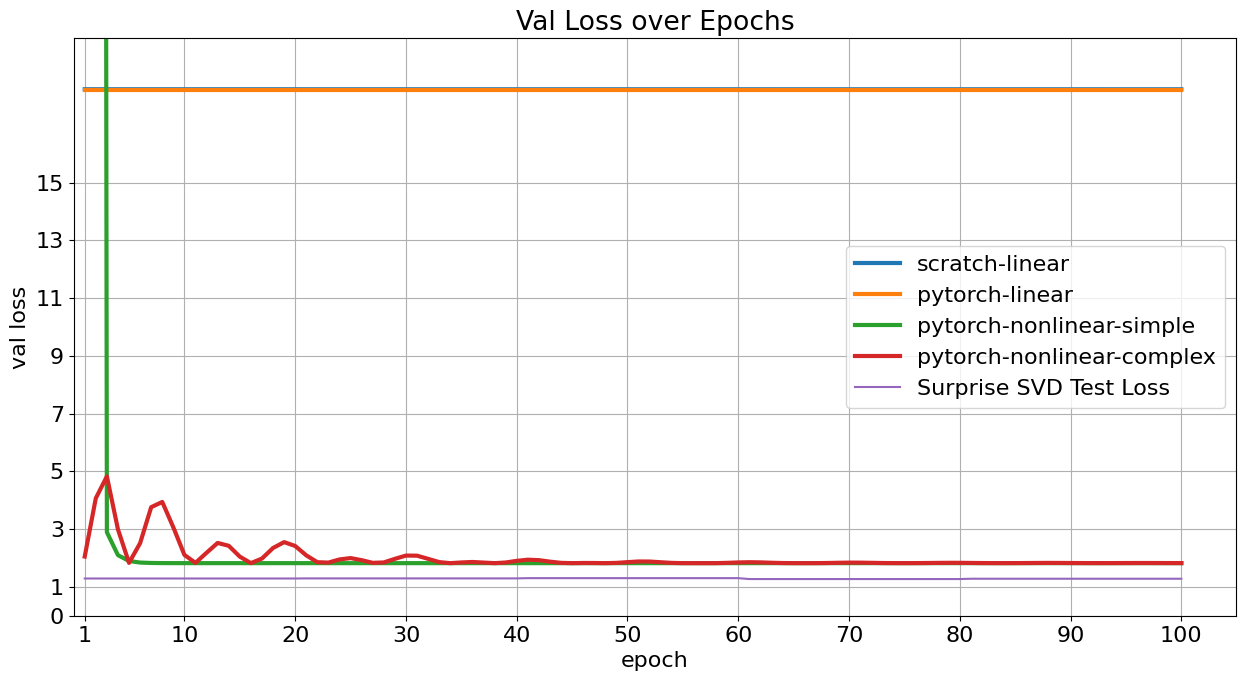

In [23]:
plot_performance(performance_dict)